# Index positional Encoding (Concatenating in 1st axis)

## Package Installation

In [1]:
import os
import sys

# Path

In [2]:
print(os.getcwd())

C:\Users\Administrator\Desktop\trails10\experiment_1_10trials


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

## Libraries

In [2]:

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle

## Data preparation

In [5]:
data = pickle.load(open(training_data_kok14_galfa, 'rb'))

# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

## Split train, validation and testing set from X_train and Y_train. (60%, 20%, 20%)

In [6]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

In [7]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

x_train= (23268, 414) , y_train= (23268, 2)
x_val= (7756, 414) , y_val= (7756, 2)
x_test= (7757, 414) , y_test= (7757, 2)


## Plot a few training samples

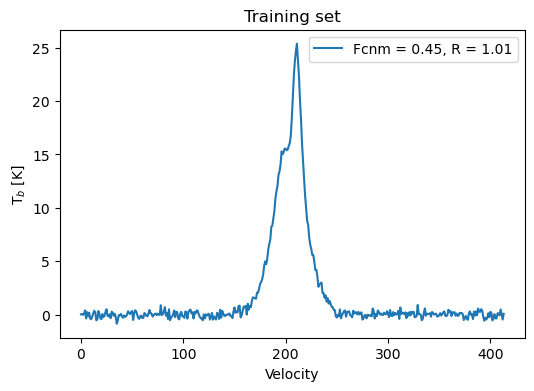

In [8]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[0, :], label=f'Fcnm = {round(Y_train[20000,0], 2)}, R = {round(Y_train[0,1], 2)}')

plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

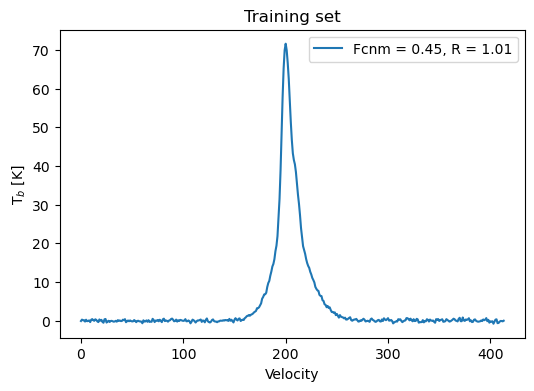

In [9]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[1000, :], label=f'Fcnm = {round(Y_train[20000,0], 2)}, R = {round(Y_train[0,1], 2)}')

plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('T$_b$ [K]')
plt.legend()
plt.show()

## Data loader

In [10]:
# data loader 
class HI_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        
        self.x = x
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.y[:,0])
    
    def __getitem__(self, idx):
        spectra = self.x[idx,:]
        label = self.y[idx,:]
        position = np.linspace(0, 1.0, 414).reshape(1, -1)
        spectra = np.vstack((spectra, position))
        if self.transform:
            spectra = self.transform(spectra)
            spectra = spectra.view(1,spectra.shape[0], spectra.shape[1])
        if self.target_transform:
            label = self.target_transform(label)
        return spectra, label

In [11]:
# transform to tenor 
class ToTensor_x():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [12]:
# transform to tenor 
class ToTensor_y():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [13]:
# initialize dataset
dataset_train = HI_dataset(x_train, y_train,transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_val = HI_dataset(x_val, y_val,transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_test = HI_dataset(x_test, y_test,transform=ToTensor_x(), target_transform=ToTensor_y())

In [14]:
# initialize data loader
batch_size = 20 
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle =True)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_val, batch_size = batch_size, shuffle =False)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle =False)

In [15]:
# test data loader
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 1, 2, 414])
torch.Size([20, 2])


## CNN Model

In [3]:
import math
class Net_origin_deep(nn.Module):
    def __init__(self, num_output=2, in_channels=1, num_output_1=72, num_output_2=64, num_output_3=56, num_output_4=48):
        super(Net_origin_deep, self).__init__()
        # layers
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels=num_output_1, 
                               kernel_size=(2,6), stride=1, padding=0, 
                               bias=True, padding_mode='zeros')
        
        self.bn1 = nn.BatchNorm2d(num_output_1)
        
        self.conv2 = nn.Conv2d(in_channels= num_output_1, out_channels=num_output_2, kernel_size=(1,40), 
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn2 = nn.BatchNorm2d(num_output_2)
            
        self.conv3 = nn.Conv2d(in_channels = num_output_2, out_channels=num_output_3, 
                               kernel_size=(1,6), stride=1, 
                               padding=0, bias=True, padding_mode='zeros')
        
        self.bn3 = nn.BatchNorm2d(num_output_3)
        self.conv4 = nn.Conv2d(in_channels= num_output_3, out_channels=num_output_4, 
                               kernel_size=(1,40), stride=1, padding=0, 
                               bias=True, padding_mode='zeros')
        
        self.bn4 = nn.BatchNorm2d(num_output_4)
        
        self.conv5 = nn.Conv2d(in_channels = num_output_4, out_channels=40,
                               kernel_size=(1,6), stride=1, padding=0, 
                               bias=True, padding_mode='zeros')
        
        self.bn5 = nn.BatchNorm2d(40)
        
        self.conv6 = nn.Conv2d(in_channels= 40, out_channels=32, kernel_size=(1,40), 
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn6 = nn.BatchNorm2d(32)
        
        self.conv7 = nn.Conv2d(in_channels = 32, out_channels=16, kernel_size=(1,6),
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn7 = nn.BatchNorm2d(16)
        
        self.conv8 = nn.Conv2d(in_channels= 16, out_channels=8, kernel_size=(1,40), 
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn8 = nn.BatchNorm2d(8)
        
        self.dropout = nn.Dropout(0.30)

        self.linear = nn.Linear(1904, num_output)
        self.flatten = nn.Flatten()

        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        #print(1, x.size())
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #print(2, x.size())
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        #print(3, x.size())
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        #
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        #
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        #
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        #
        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)
        #
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)
        #
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        #print(4, x.size())
        return x

## Model Training and Evaluation 

In [17]:
# train 
def train(epoch):
    model.train()
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward
        outputs = model(inputs)
        loss = loss_function(outputs, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
    print("total loss=",train_loss)
    return train_loss/total

In [18]:
def validation(epoch):
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    # Save checkpoint.
    error =  test_loss / total
    print(f"validation MSE in epoch {epoch}= ", error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/index_concatenate_s2.pth')
        best_err = error
    return error

In [19]:
def test(epoch):
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        #print(f'Test performance in epoch {epoch}: avg_error = {test_loss/total}')
        return test_loss/total

# Start 10 trail Training

In [20]:
# define number of trails, number of epoch and learning rate
num_trial = 10
num_epoch = 80
learning_rate = 0.005
# the savier of best validation performance and coresponding testing performance.
vali = []
testing = []
# saver for each trials
train_trails = []
validate_trails =[]
test_trails = []

In [21]:
def trail(num_epoch):
    global vali
    global testing
    global scheduler
    global model
    global lr
    #define savor
    global train_trails
    global validate_trails
    global test_trails
    for epoch in range(num_epoch):
        train_err = train(epoch)
        vali_err = validation(epoch)
        scheduler.step()
        test_err = test(epoch)
        # save data
        train_trails.append(train_err)
        validate_trails.append(vali_err)
        test_trails.append(test_err)
    # final test
    validation_error,test_error = validate_model()
    print("test err=",test_error)
    vali.append(validation_error)
    testing.append(test_error)

In [22]:
def validate_model():
    global model
    model = Net_origin_deep()
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    checkpoint = torch.load('./checkpoint/index_concatenate_s2.pth',
                            map_location=torch.device('cuda:0'))
    model.load_state_dict(checkpoint['net'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    validation_error = validation(epoch)
    test_error = test(epoch)
    return validation_error, test_error

In [23]:
# start 10 trails.
for i in range (0, num_trial):
    print(f'start the {i}th trial:')
    # model initialization
    lr=learning_rate
    model = Net_origin_deep()
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    optimizer = torch.optim.SGD(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                     milestones = [65], 
                                                     gamma=0.1, last_epoch=-1, 
                                                     verbose=False)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    trail(num_epoch)

start the 0th trial:
total loss= 575.6390719413757
validation MSE in epoch 0=  0.008449737845282173
best_err: 0.008449737845282173 Saving..
total loss= 354.14743612799793
validation MSE in epoch 1=  0.008846324414906754
total loss= 295.09233948402107
validation MSE in epoch 2=  0.00915376062549616
total loss= 264.46173005132005
validation MSE in epoch 3=  0.007500389381143725
best_err: 0.007500389381143725 Saving..
total loss= 242.55180920427665
validation MSE in epoch 4=  0.007449156032416963
best_err: 0.007449156032416963 Saving..
total loss= 225.27363864518702
validation MSE in epoch 5=  0.010951307168986424
total loss= 211.892869213596
validation MSE in epoch 6=  0.007302425561958848
best_err: 0.007302425561958848 Saving..
total loss= 190.1637305188924
validation MSE in epoch 7=  0.00906145635309887
total loss= 180.1037405799143
validation MSE in epoch 8=  0.0062879592211412235
best_err: 0.0062879592211412235 Saving..
total loss= 169.9757093708031
validation MSE in epoch 9=  0.0051

# plot traing process

## plot the training and validation and testing chart

In [24]:
def plott(x, ti):
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

In [25]:
def plott_20(x, ti):
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index+59: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails(last 20 epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()

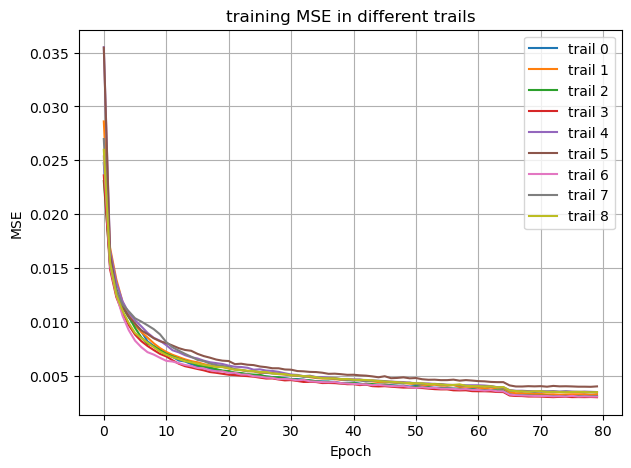

In [26]:
# training 
x = np.array(train_trails)
plott(x, "training")

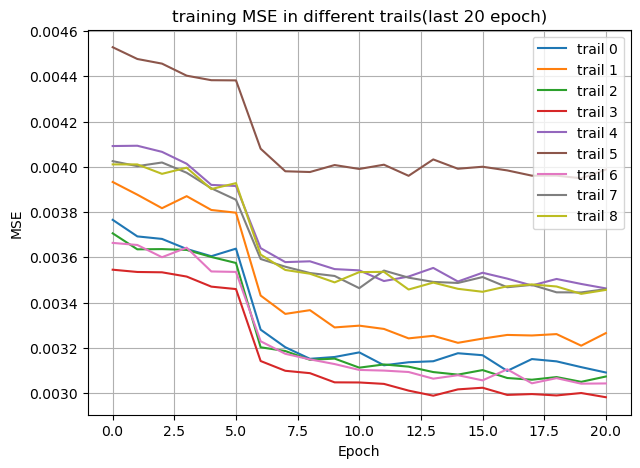

In [27]:
# training 
x = np.array(train_trails)
plott_20(x, "training")

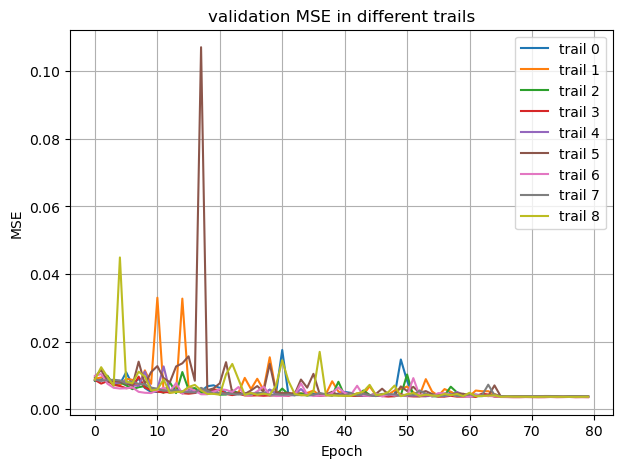

In [28]:
# validation
x = np.array(validate_trails)
plott(x, "validation")

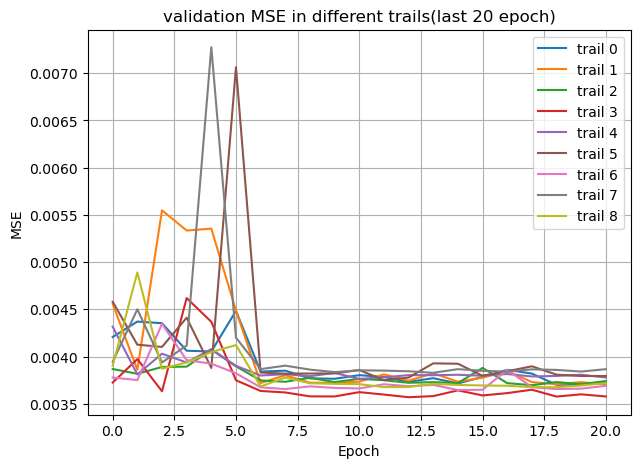

In [29]:
# validation
x = np.array(validate_trails)
plott_20(x, "validation")

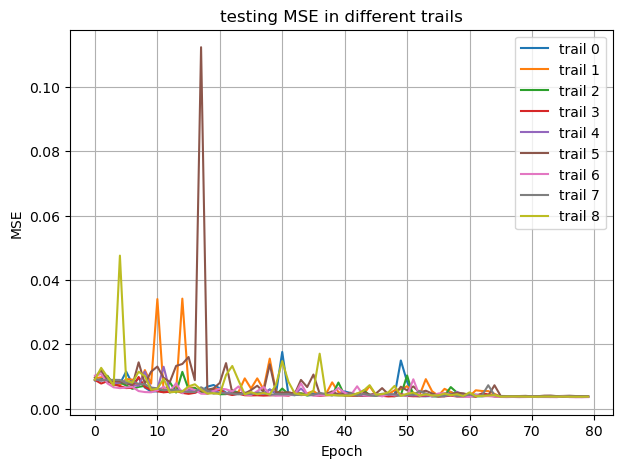

In [30]:
# testing 
x = np.array(test_trails)
plott(x, "testing")

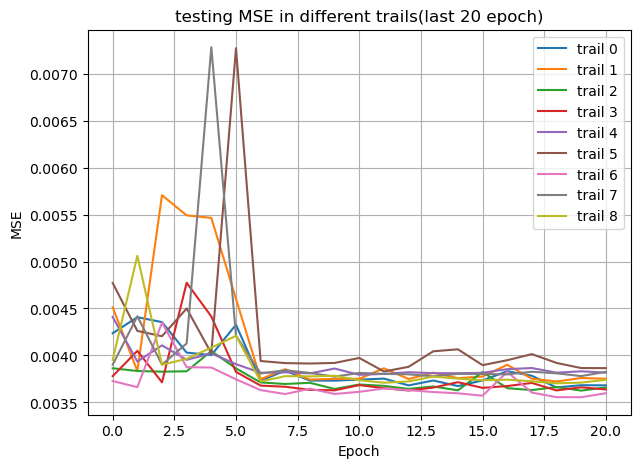

In [31]:
# testng
x =  np.array(test_trails)
plott_20(x, "testing")

## plot the best velidation MSE and testing MSE

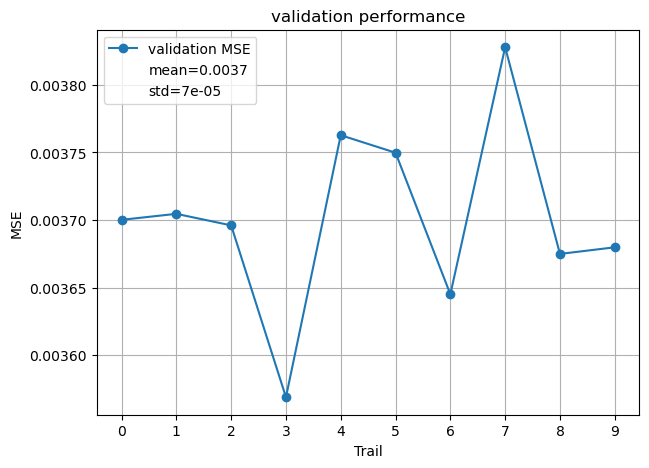

validation mean= 0.0037010227449146083
validation std= 6.628848492013652e-05


In [32]:
x = vali
plt.figure(figsize=(7,5))
plt.title('validation performance')
plt.plot(x, label='validation MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),5)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),5)}")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("validation mean=",np.mean(x))
print("validation std=",np.std(x))

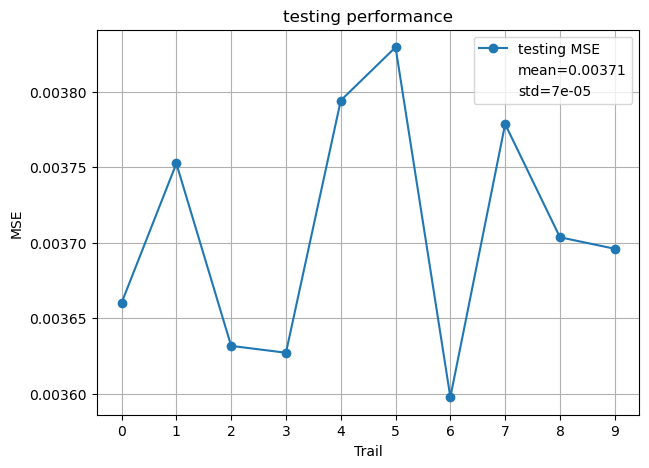

testing mean= 0.003707124396713312
testing std= 7.494038144945226e-05


In [33]:
x = testing
plt.figure(figsize=(7,5))
plt.title('testing performance')
plt.plot(x, label='testing MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),5)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),5)}")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("testing mean=",np.mean(x))
print("testing std=",np.std(x))

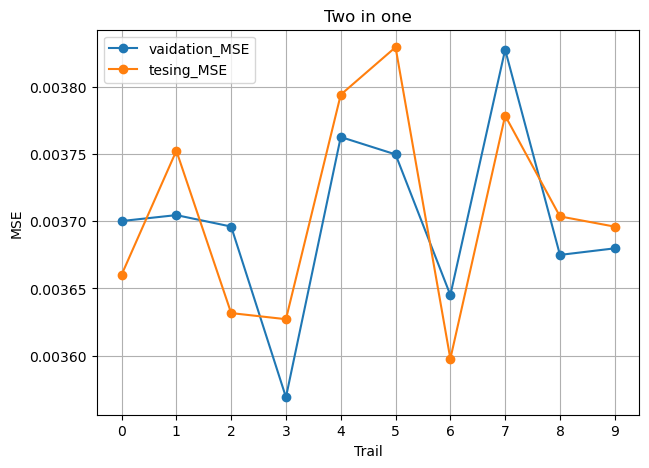

In [34]:
x1 = vali
x2 = testing
plt.figure(figsize=(7,5))
plt.title('Two in one')
plt.plot(x1, label='vaidation_MSE',marker='o')
plt.plot(x2, label='tesing_MSE',marker='o')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

## Save CSV

In [35]:
x1 = np.array(vali).reshape(1, -1)
x2 = np.array(testing).reshape(1, -1)
two = np.vstack((x1,x2))
df = pd.DataFrame(two).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\index_concatenate_s2.csv")

In [36]:
# save data 
x1 = np.array(train_trails).reshape(1, -1)
x2 = np.array(validate_trails).reshape(1, -1)
x3 = np.array(test_trails).reshape(1, -1)
three = np.vstack((x1,x2,x3))
df = pd.DataFrame(three).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\index_concatenate_whole_s2.csv")